### 2번
5분간격의 가구별 전력 사용량의 데이터
데이터 출처 : 자체생성

In [141]:
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

data_path = '../data/problem2.csv'

df = pd.read_csv(data_path)
df.head()

,houseCode,date,power consumption
0,house_01,2050-01-14 21:00:00,57.559878
1,house_26,2050-01-02 19:10:00,59.726880
2,house_25,2050-01-13 07:20:00,6.558823
3,house_20,2050-01-26 04:55:00,58.514589
4,house_09,2050-01-18 22:50:00,5.717009


2-1 데이터 전처리

각 가구의 15분간격의 전력량의 합을 구하고 해당데이터를 바탕으로 총 5개의 군집으로 군집화를 진행한 후 아래의 그림과 같은 형태로 출력하라.
군집화를 위한 데이터 구성의 이유를 설명하라
(군집 방식에 따라 Cluster컬럼의 값은 달라질수 있음)

<img width="1020" src="https://user-images.githubusercontent.com/97590480/236660968-0e59b0f9-5540-40dc-9b05-53ef6fc5a29a.png">

In [161]:
import matplotlib.pyplot as plt
ttt = pd.read_csv(data_path)
tt = ttt.sort_values(['houseCode','date']).reset_index(drop=True)

tt['date'] = pd.to_datetime(tt['date'])

tg = tt.groupby(['houseCode']).resample('15min', on='date')['power consumption'].sum().reset_index()

tg = tg.rename(columns= {'power consumption':'power consumption sum'})

tgg = tg.copy()

tgg['c'] =tgg['houseCode'].str[-2:].astype('int')
tgg['d'] =tgg['date'].dt.hour
tgg['e'] =tgg['date'].dt.day

tgg

# from sklearn.cluster import KMeans 

# # k-means clustering 실행
# kmeans = KMeans(n_clusters=5, random_state=42)
# kmeans.fit(tgg.iloc[:,2:].values)

# tg['Cluster'] =kmeans.labels_

# tg

,houseCode,date,power consumption sum,c,d,e
0,house_00,2050-01-01 00:00:00,136.249952,0,0,1
1,house_00,2050-01-01 00:15:00,98.283387,0,0,1
2,house_00,2050-01-01 00:30:00,53.967679,0,0,1
3,house_00,2050-01-01 00:45:00,204.821270,0,0,1
4,house_00,2050-01-01 01:00:00,150.760786,0,1,1
...,...,...,...,...,...,...
133915,house_44,2050-01-31 22:45:00,334.675717,44,22,31
133916,house_44,2050-01-31 23:00:00,463.419892,44,23,31
133917,house_44,2050-01-31 23:15:00,369.930740,44,23,31
133918,house_44,2050-01-31 23:30:00,237.713030,44,23,31


In [176]:
# 시계열 전처리 진행

df = pd.read_csv(data_path)
df['date'] = pd.DatetimeIndex(df['date'])
df = df.set_index('date')
df = df.groupby('houseCode').resample('15min').sum()
df = df.reset_index().rename({'power consumption' : 'power consumption sum'}, axis=1)
df

,houseCode,date,power consumption sum
0,house_00,2050-01-01 00:00:00,136.249952
1,house_00,2050-01-01 00:15:00,98.283387
2,house_00,2050-01-01 00:30:00,53.967679
3,house_00,2050-01-01 00:45:00,204.821270
4,house_00,2050-01-01 01:00:00,150.760786
...,...,...,...
133915,house_44,2050-01-31 22:45:00,334.675717
133916,house_44,2050-01-31 23:00:00,463.419892
133917,house_44,2050-01-31 23:15:00,369.930740
133918,house_44,2050-01-31 23:30:00,237.713030


## K-means 알고리즘

K-means 알고리즘은 어떤 임의의 군집 중심 지점을 설정하여 그 지점과 각 데이터들간의 거리를 측정한 후,

군집 지점과 데이터들간의 평균 거리가 최소가 되게끔 군집의 중심을 지속적으로 조정하는 알고리즘이다.

이 경우 시작지점에 따라 군집이 달라질 수 있으며, 군집의 갯수를 임의로 설정해줘야 하는 문제가 있다.

최적의 군집의 갯수를 구하는 기법인 실루엣 기법이나 엘보우 기법 등이 있으나

본 문제에서는 군집의 갯수가 주어지므로 휴리스틱하게 설정되어 있다고 가정한다.

또한, power consumption sum뿐만 아니라 date 컬럼도 중요한 변수 중 하나이므로, 시계열의 주기성을 반영하기 위해 주, 일, 시간 단위로 feature engineering하여 군집화를 진행한다.


In [177]:
features = df.copy()
features['houseCode'] = features['houseCode'].apply(lambda x: int(x[-2:]))
features['day'] = features['date'].dt.day
features['hour'] = features['date'].dt.hour
features['min'] = features['date'].dt.time
convert_min2num = {min : num for num, min in enumerate(features['min'].unique())}
features['min'] = features['min'].apply(lambda x: convert_min2num[x])
features = features.drop('date', axis=1)
# features['time'] = features['date'].dt.time.apply(lambda x: int(str(x).split(':')[0]) * 60 + int(str(x).split(':')[1]))
features

,houseCode,power consumption sum,day,hour,min
0,0,136.249952,1,0,0
1,0,98.283387,1,0,1
2,0,53.967679,1,0,2
3,0,204.821270,1,0,3
4,0,150.760786,1,1,4
...,...,...,...,...,...
133915,44,334.675717,31,22,91
133916,44,463.419892,31,23,92
133917,44,369.930740,31,23,93
133918,44,237.713030,31,23,94


In [178]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(features)

df['Cluster'] = kmeans.labels_
df

,houseCode,date,power consumption sum,Cluster
0,house_00,2050-01-01 00:00:00,136.249952,1
1,house_00,2050-01-01 00:15:00,98.283387,1
2,house_00,2050-01-01 00:30:00,53.967679,1
3,house_00,2050-01-01 00:45:00,204.821270,2
4,house_00,2050-01-01 01:00:00,150.760786,2
...,...,...,...,...
133915,house_44,2050-01-31 22:45:00,334.675717,0
133916,house_44,2050-01-31 23:00:00,463.419892,3
133917,house_44,2050-01-31 23:15:00,369.930740,0
133918,house_44,2050-01-31 23:30:00,237.713030,4


#### 2-2 히트맵

2-1의 데이터를 바탕으로 각 군집의 요일, 15분간격별 전력사용량의 합을 구한 후 아래와 같이 시각화 하여라
(수치는 동일하지 않을 수 있음 2-1의 데이터가 정확하게 아래와 같은 이미지로 변환 됐는지 주로 확인)

<img width="878" src="https://user-images.githubusercontent.com/97590480/236660988-679620bb-d51f-4b69-9c33-edee958dc032.png">


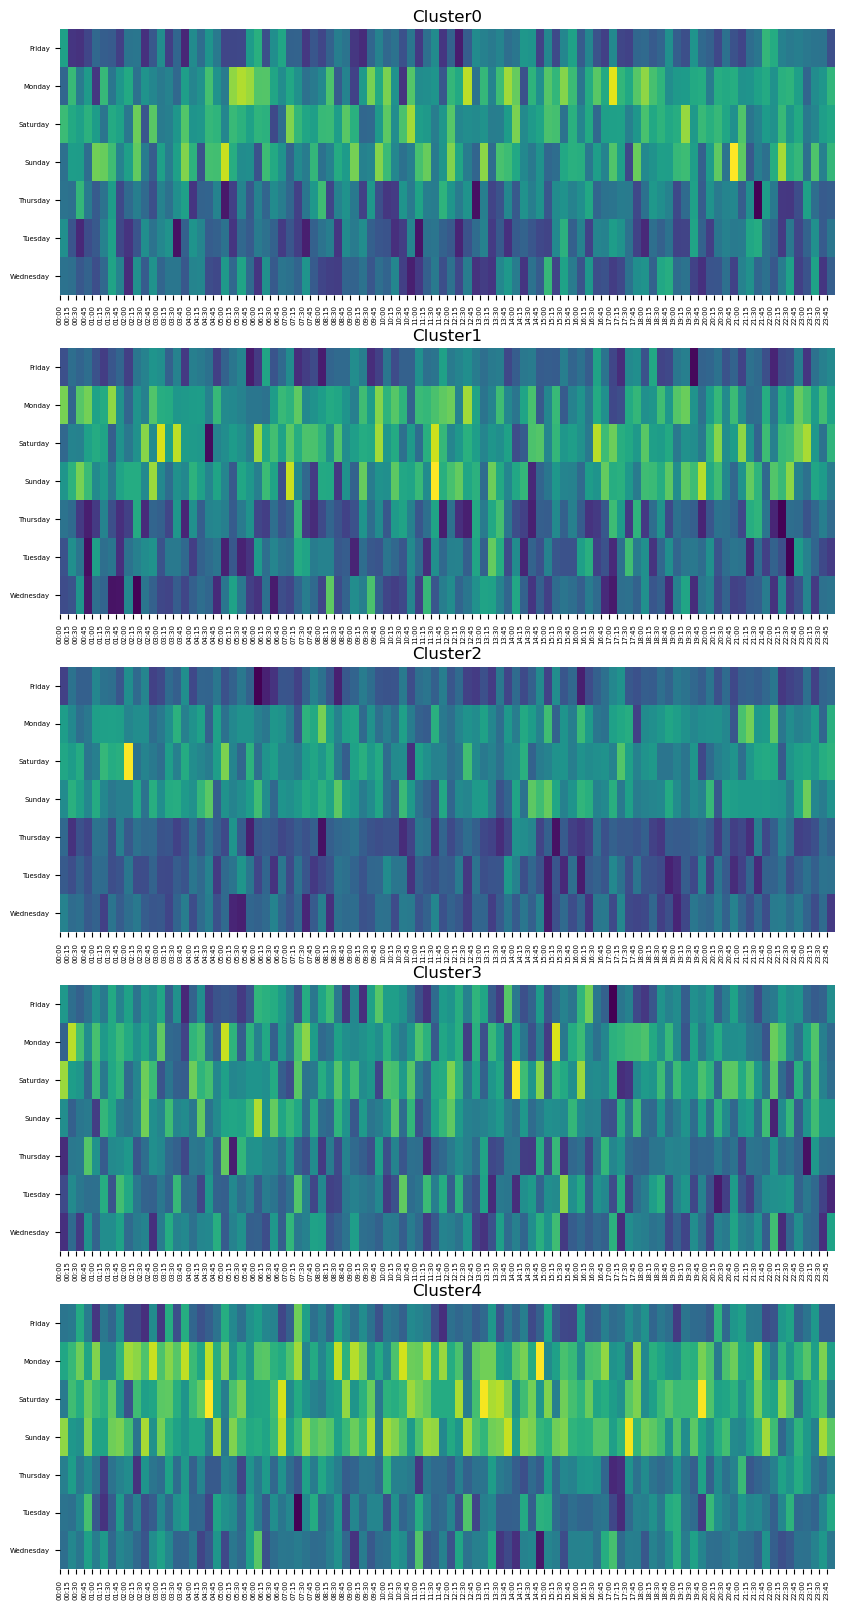

In [207]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(10, 20))
df['weekday'] = df['date'].dt.day_name()
df['time'] = df['date'].dt.strftime('%H:%M')
grouped = df.groupby(['Cluster','weekday', 'time'], as_index=False).sum()

for i in range(5):
    pivot = grouped[grouped['Cluster'] == i].pivot(index='weekday', columns='time', values='power consumption sum')
    sns.heatmap(pivot, ax=axes[i], cmap='viridis', cbar=False)
    axes[i].set_xticks(range(len(pivot.columns)),pivot.columns,rotation=90, fontsize=5)
    axes[i].set_yticks(np.arange(len(pivot.index))+0.5,pivot.index, fontsize=5)
    axes[i].set_title(f'Cluster{i}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    
plt.show()